In [2]:
import sys
sys.path.append('C:/Users/flapet/OneDrive - NOC/Documents/utils_python')


In [3]:
from functions.general import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

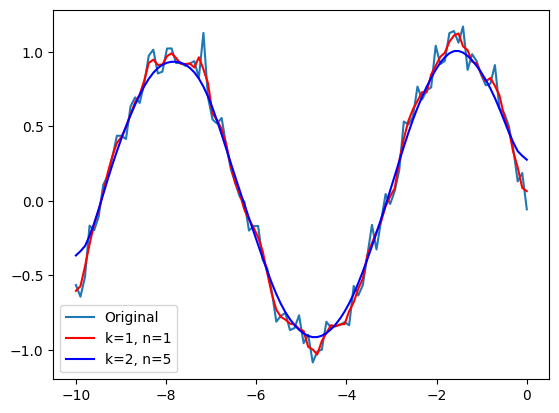

In [4]:
depth = np.linspace(0, 10, 100)
chla = np.sin(depth) + np.random.normal(0, 0.1, len(depth))

plt.plot(-depth, chla, label='Original')
plt.plot(-depth, slide(chla), label='k=1, n=1', color='red')
plt.plot(-depth, slide(chla, k=2, n=5), label='k=2, n=5', color='blue')

plt.legend()
plt.show()

In [4]:
import xarray as xr

In [5]:
path = 'C:/Users/flapet/OneDrive - NOC/Documents/NRT_viz/biocarbon_nrt_data_viz/Data/Gliders/Doombar_648_R.nc'
dat = xr.open_dataset(path)

In [6]:
import xarray as xr
import numpy as np
from scipy import signal 
def boxcar_smooth_dataset(dataset, window_size):
    """Smooth data with a simple box car filter
    """
    window = signal.windows.boxcar(window_size)
    return signal.convolve(dataset, window, 'same') / window_size

def find_profiles_by_depth(db, tsint=2, winsize=10):
    """Discovery of profiles in a glider segment using depth and time.

    Profiles are discovered by smoothing the depth timeseries and using the
    derivative of depth vs time to find the inflection points to break
    the segment into profiles.  Profiles are truncated to where science
    data exists; science sensors for the glider are configured in
    Configuration.py.
    Depth can be `DEPTH_SENSOR` as configured in configuration.py or
    CTD pressure (Default `DEPTH_SENSOR`).  For smoothing
    a filtered depth is created at regular time intervals `tsint` (default
    2 secs) and boxcar filtered with window `winsize` (default 5 points).
    The smoothing is affected by both choice of `tsint` and `winsize`, but
    usually still returns similar profiles.  After profiles are discovered,
    they should be filtered with the `filter_profiles` method of this
    class, which removes profiles that are not true profiles.

    :param depth_sensor: The Depth sensor to use for profile discovery.
    Should be either the configured `DEPTH_SENSOR`, or CTD pressure
    `PRESSURE_SENSOR` (configured in configuration.py), or a
    derivative of those 2.  Default is `DEPTH_SENSOR`
    :param tsint: Time interval in seconds for filtered depth.
    This affects filtering.  Default is 2.
    :param winsize: Window size for boxcar smoothing filter.
    :return: output is a list of profile indices in self.indices
    """
    indices = []

    dat = xr.open_dataset(db)

    depth = dat['PRES'].values
    ts = dat.N_MEASUREMENTS.values
    time_ = dat.N_MEASUREMENTS.values

    # Set negative depth values to NaN; using this method to avoid numpy
    # warnings from < when nans are in the array
    depth_ii = np.flatnonzero(np.isfinite(depth))  # non-nan indices
    neg_depths = np.flatnonzero(depth[depth_ii] <= 0)  # indices to depth_ii
    depth[depth_ii[neg_depths]] = np.nan

    # Remove NaN depths and truncate to when science data begins being
    # recorded and ends
    depth_ii = np.flatnonzero(np.isfinite(depth))

    sci_indices = dat.N_MEASUREMENTS.values  # from ooidac.processing
    if len(sci_indices) > 0:
        starting_index = sci_indices[0]
        ending_index = sci_indices[-1]
    else:
        print(f'No data in {db}')
        return  # no science_indices, then we don't care to finish

    depth_ii = depth_ii[
        np.logical_and(
            depth_ii >= starting_index,
            depth_ii <= ending_index)
    ]

    # ---Create a smoothed depth timeseries for finding inflections ------#

    # Find start and end times first adding winsize * tsint timesteps
    # onto the start and end to account for filter edge effects
    itime_start = np.ceil(ts[depth_ii].min()) - winsize * tsint
    itime_end = np.floor(ts[depth_ii].max()) + (winsize + 1) * tsint

    itime = np.arange(itime_start, itime_end, tsint)
    idepth = np.interp(itime, ts[depth_ii], depth[depth_ii],
                        left=depth[depth_ii[0]], right=depth[depth_ii[-1]])
    fz = boxcar_smooth_dataset(idepth, winsize)

    # remove the extra points with filter edge effects
    # ? isn't that why we trim itime_[start,end] by the window size?
    fz = fz[winsize:-winsize]
    itime = itime[winsize:-winsize]
    idepth = idepth[winsize:-winsize]

    # Zero crossings of the time derivative of filtered depth are the
    # inflection points.  Differential time is midway between the
    # filtered timestamps.
    # Originally, this used scipy's fsolver to locate the exact zero
    # crossing, but only the timestamp before the zero crossing is needed
    # to be the last in a profile and the timestamp after the zero
    # crossing to be the first in the next profile.

    dz_dt = np.diff(fz) / np.diff(itime)
    dtime = itime[:-1] + np.diff(itime) / 2  # differential time

    # Get the time point just after a zero crossing.  The flatnonzero
    # statement below gets the point before a zero crossing.
    zero_crossings_ii = np.flatnonzero(abs(np.diff(np.sign(dz_dt))))
    zc_times = dtime[zero_crossings_ii] + (
            dtime[zero_crossings_ii + 1] - dtime[zero_crossings_ii]) / 2.

    profile_switch_times = zc_times[np.logical_and(
        zc_times > time_[starting_index],
        zc_times < time_[ending_index]
    )]
    # insert the timestamp of the first science data point at the start
    # and the last data point at the end.
    profile_switch_times = np.insert(
        profile_switch_times, [0, len(profile_switch_times)],
        [time_[starting_index],
            time_[ending_index]])

    inflection_times = profile_switch_times

    # profile_switch_times = self.adjust_inflections(depth, time_)
    profile_switch_times = adjust_inflections(depth, time_, inflection_times)

    # use the time range to gather indices for each profile
    for ii in range(len(profile_switch_times)-1):
        pstart = profile_switch_times[ii]
        pend = profile_switch_times[ii+1]
        profile_ii = np.flatnonzero(
            np.logical_and(
                time_ >= pstart,
                time_ <= pend))  # inclusive since before the inflection
        if len(profile_ii) == 0:
            continue
        indices.append(profile_ii)
    
    return(indices)

def adjust_inflections(depth, time_, inflection_times):
    """Filters out bad inflection points.

    Bad inflection points are small surface, bottom of dive, or mid-profile
    wiggles that are not associated with true dive or climb inflections.
    These false inflections are removed so that when profile indices are
    created, they don't separate into separate small profiles.

    :param depth:
    :param time_:
    :return:
    """
    inflections = inflection_times
    inflection_depths = np.interp(
        inflections, time_[np.isfinite(depth)],
        depth[np.isfinite(depth)]
    )

    # First remove the false diving inflections (i.e. the small wiggles) by
    # taking the good inflection and looking ahead until an inflection depth
    # difference greater than 2m is found
    inflx_ii = 0
    fwd_counter = 1
    inflx_to_keep = np.full(len(inflections), True)
    while inflx_ii < len(inflections):
        ii_depth = inflection_depths[inflx_ii]  # depth of current inflection
        # look ahead for the next true inflection change
        if inflx_ii + fwd_counter >= len(inflections):
            break
        while abs(inflection_depths[inflx_ii + fwd_counter] - ii_depth) < 2:
            inflx_to_keep[inflx_ii + fwd_counter] = False
            fwd_counter += 1
            if inflx_ii + fwd_counter >= len(inflections):
                break
        inflx_ii = inflx_ii + fwd_counter
        fwd_counter = 1

    # afterwards we may be left with mid profile direction changes that were
    # greater than 2 m.  But now they can identified by not changing trend,
    # since any of our good  inflection points left will change trend sign.
    good_inflx_ii = np.flatnonzero(inflx_to_keep)
    trends = np.diff(inflection_depths[good_inflx_ii])
    # find where the trends are the same by getting the diff of the sign of
    # the trend (which is also a diff).  Must add one because diff always
    # results in N-1
    same_trends = np.flatnonzero(np.diff(np.sign(trends)) == 0) + 1
    good_inflx_ii = np.delete(good_inflx_ii, same_trends)
    inflection_times = inflections[good_inflx_ii]

    return inflection_times

In [7]:
path = 'C:/Users/flapet/OneDrive - NOC/Documents/NRT_viz/biocarbon_nrt_data_viz/Data/Gliders/Doombar_648_R.nc'
prof_indexes  = find_profiles_by_depth(path)

In [9]:
from tqdm import tqdm

In [8]:
depth = dat['PRES'].values
itime = dat.N_MEASUREMENTS.values
fwd_counter = 10
surfaces = []

depth_ii = np.flatnonzero(np.isfinite(depth))  # non-nan indices
neg_depths = np.flatnonzero(depth[depth_ii] <= 0)  # indices to depth_ii
depth[depth_ii[neg_depths]] = np.nan

# Remove NaN depths and truncate to when science data begins being
# recorded and ends
depth_ii = np.flatnonzero(np.isfinite(depth))

idepth = np.interp(itime, itime[depth_ii], depth[depth_ii],
                        left=depth[depth_ii[0]], right=depth[depth_ii[-1]])
fz = boxcar_smooth_dataset(idepth, 10)

for i in tqdm(range(len(prof_indexes))):
    profile_depth = fz[prof_indexes[i]]
    depth_ii = 0
    surface = []

    while depth_ii < len(profile_depth):
        ii_depth = profile_depth[depth_ii]

        # Look ahead for the next true inflection change
        if depth_ii + fwd_counter >= len(profile_depth):
            break
        if abs(profile_depth[depth_ii + fwd_counter] - ii_depth) < 2:
            surface.extend(range(depth_ii, depth_ii + fwd_counter + 1))

        depth_ii += 1

    surfaces.append(surface)


NameError: name 'tqdm' is not defined

In [88]:
depth = dat['PRES'].values
itime = dat.N_MEASUREMENTS.values
fwd_counter = 10
threshold = 2  # Threshold for detecting minimal change in depth
surfaces = []

# Find indices with finite (non-NaN) depths
depth_ii = np.flatnonzero(np.isfinite(depth))
neg_depths = np.flatnonzero(depth[depth_ii] <= 0)
depth[depth_ii[neg_depths]] = np.nan

# Recompute finite indices after replacing depths <= 0 with NaN
depth_ii = np.flatnonzero(np.isfinite(depth))

# Interpolate the depths for the measurements
idepth = np.interp(itime, itime[depth_ii], depth[depth_ii],
                   left=depth[depth_ii[0]], right=depth[depth_ii[-1]])
fz = boxcar_smooth_dataset(idepth, 10)

for i in tqdm(range(len(prof_indexes))):
    profile_depth = fz[prof_indexes[i]]
    depth_ii = 0
    surface = []

    while depth_ii < (len(profile_depth) - fwd_counter):
        # Check if the pressure changes minimally over the next `fwd_counter` points
        if abs(profile_depth[depth_ii] - profile_depth[depth_ii + fwd_counter]) < threshold:
            surface.append(depth_ii)
            last_valid_depth = depth_ii  # Update to track the last valid `depth_ii`
            depth_ii += 1  # Skip forward to avoid overlapping ranges
        else:
            depth_ii += 1

    # After exiting the loop, append the last valid range if it exists
    if last_valid_depth is not None:
        surface.extend(list(range(last_valid_depth, last_valid_depth + fwd_counter)))
        
    surfaces.append(surface)


100%|██████████| 1676/1676 [00:02<00:00, 804.26it/s]


In [60]:
test = [0,1,2,3]
test.extend(list(range(100, 100 + 10)))
test

[0, 1, 2, 3, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]

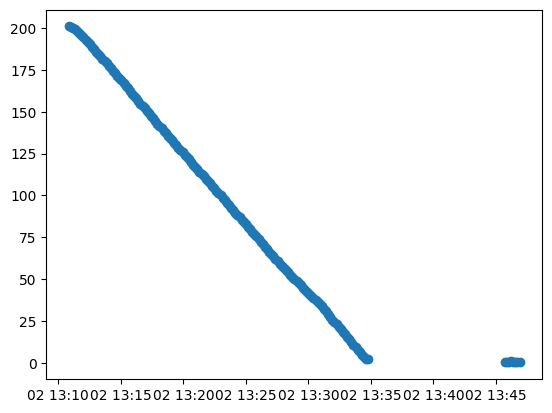

In [89]:
i = 157
prof_number = i
prof_165 = prof_indexes[prof_number]
pos = surfaces[prof_number]
surface_165 = prof_indexes[prof_number][pos]
pres = [pos_value for pos_value in dat['PRES'][prof_165].values if pos_value not in pos]
time = [pos_value for pos_value in dat['TIME'][prof_165].values if pos_value not in pos]
# pres_surf = pres[surfaces[prof_number]]
# time_surf = time[surfaces[prof_number]]
# new_y = pres_surf[np.flatnonzero(np.isfinite(pres_surf))]
# new_x = time_surf[np.flatnonzero(np.isfinite(pres_surf))]


# Identify indices of valid and NaN values
nans = np.isnan(pres)
valid = ~nans

# Interpolate the NaN values
#pres[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(valid), pres[valid])

plt.scatter(time, pres)
#plt.scatter(time_surf, pres_surf, c = 'Red')
plt.show()

In [ ]:
for i in tqdm(range(100)):
    prof_number = i
    prof_165 = prof_indexes[prof_number]
    surface_165 = prof_indexes[prof_number][surfaces[prof_number]]
    pres = dat['PRES'][prof_165].values
    time = dat['TIME'][prof_165].values
    pres_surf = dat['PRES'][surface_165].values
    time_surf = dat['TIME'][surface_165].values
    time_surf = dat['TIME'][surface_165].values
    new_y = pres_surf[np.flatnonzero(np.isfinite(pres_surf))]
    new_x = time_surf[np.flatnonzero(np.isfinite(pres_surf))]

    # Identify indices of valid and NaN values
    nans_surf = np.isnan(pres_surf)
    valid_surf = ~nans_surf

    if any(nans_surf):

        # Interpolate the NaN values
        pres_surf[nans_surf] = np.interp(np.flatnonzero(nans_surf), np.flatnonzero(valid_surf), pres_surf[valid_surf])
    # Identify indices of valid and NaN values
    nans = np.isnan(pres)
    valid = ~nans

    # Interpolate the NaN values
    pres[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(valid), pres[valid])

    plt.scatter(time, pres)
    plt.scatter(new_x, new_y, c = 'Red')
    plt.savefig('C:/Users/flapet/OneDrive - NOC/Documents/NRT_viz/Output/loop/' + str(i) + '.png')
    plt.close()

In [96]:
cleaned_pres =  np.compress(~np.isnan(pres), pres)

In [ ]:
cleaned_pres

In [ ]:
current_data = pd.read_csv("C:/Users/flapet/OneDrive - NOC/Documents/NRT_viz/biocarbon_nrt_data_viz/gliders_dac.csv")

min_lon = -19
max_lon = -18
min_lat = 59
max_lat = 61


#extract the lon and lat from the dataset only once
x = current_data['m_lon']
y = current_data['m_lat']


#From the U and V vector compute the speed, we use it as our colour map
u = current_data['m_water_vx']
v = current_data['m_water_vy']
speed = np.sqrt(u**2 + v**2)

#Set up the plot layout, extent and title
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
#ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

#Plot the current vectors field and the coastline
im = ax.quiver(x, y, u, v, speed, angles='xy', scale_units='xy', cmap='viridis', transform=ccrs.PlateCarree())

#format the color bar
cbar = plt.colorbar(im, ax = ax, label=r'Depth averaged current (m s$^{-1}$)')
cbar.set_label(r'Depth averaged current (m s$^{-1}$)', rotation=270, labelpad=15)

#save the plot and then close it to avoid high memory usage
plt.show()

In [ ]:
import cartopy.feature as cfeature

# Extract the lon and lat from the dataset only once
x = current_data['m_lon']
y = current_data['m_lat']

# From the U and V vector compute the speed, we use it as our color map
u = current_data['m_water_vx']
v = current_data['m_water_vy']
speed = np.sqrt(u**2 + v**2)

# Set up the plot layout, extent and title
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

# Plot the current vectors field and the coastline
im = ax.quiver(x, y, u, v, speed, angles='xy', scale_units='xy', cmap='viridis', transform=ccrs.PlateCarree())

# Format the color bar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', label=r'Depth averaged current (m s$^{-1}$)')
cbar.set_label(r'Depth averaged current (m s$^{-1}$)', rotation=270, labelpad=15)

# Save the plot and then close it to avoid high memory usage
plt.show()
plt.clf()
plt.close()

In [ ]:
import cartopy.feature as cfeature

# Extract the lon and lat from the dataset only once
x = current_data['m_lon']
y = current_data['m_lat']

# From the U and V vector compute the speed, we use it as our color map
u = current_data['m_water_vx']
v = current_data['m_water_vy']
speed = np.sqrt(u**2 + v**2)

# Set up the plot layout, extent and title
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

# Plot the current vectors field and the coastline
im = ax.quiver(x, y, u, v, speed, angles='xy', scale_units='xy', cmap='viridis', transform=ccrs.PlateCarree())

# Format the color bar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', label=r'Depth averaged current (m s$^{-1}$)')
cbar.set_label(r'Depth averaged current (m s$^{-1}$)', rotation=270, labelpad=15)

# Save the plot and then close it to avoid high memory usage
plt.show()
plt.clf()
plt.close()